# Seasonal Averages

## libraries imports

In [1]:
library(tidyverse)
library(tidyr)
library(dplyr)
library(ggplot2)
library(readxl)
library(openxlsx)


-- Attaching core tidyverse packages ---------------------------------------------------------------- tidyverse 2.0.0 --
v dplyr     1.1.2     v readr     2.1.4
v forcats   1.0.0     v stringr   1.5.1
v ggplot2   3.4.2     v tibble    3.2.1
v lubridate 1.9.2     v tidyr     1.3.0
v purrr     1.0.1     
-- Conflicts ---------------------------------------------------------------------------------- tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()
i Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


In [2]:
Sys.setlocale("LC_TIME","C")
options(stringsAsFactors=FALSE)
theme_set(theme_bw()) # just my preference for plots

[1] "C"

## data imports

In [3]:
read_met <- function(filename) {
  data <- read_table(filename, skip=15, 
    col_names= c("year", "month", "day", "hour", "minute", "WIRI", "WIGE"),
    col_types = paste(collapse = "", c(rep("i", 5), rep("n", 2))))
  data %>%
    mutate(datetime = make_datetime(year, month, day, hour, minute, tz = "Etc/GMT-1"),
           year     = year(datetime),
           month    = month(datetime),
           day      = day(datetime),
           hour     = hour(datetime),
           minute   = minute(datetime),
           WIRI     = ifelse(WIRI <= -9999, NA, WIRI),
           WIGE     = ifelse(WIGE <= -9999, NA, WIGE))
}

In [4]:
month2season <- function(month) {
  ## month is an integer (1-12)
  ## a factor with levels {"Winter : DJF", "Spring : MAM", "Summer : JJA", "Autumn : SON"} is returned
  seasons <- c("Winter", "Spring", "Summer", "Autumn")
  index <- findInterval(month %% 12, seq(0, 12, 3))
  factor(seasons[index], seasons)
}

wday2type <- function(wday) {
  ## wday is an integer with 1 = Monday, 2 = Tuesday, ... and 7 = Sunday
  c("Weekday", "Weekend")[(unclass(wday) - 1) %/% 5 + 1]
}

In [5]:
read_tseries <- function(filename, timecolumn = "Date/time", timeformat = "%d.%m.%Y %H:%M", tz = "Etc/GMT-1", delta = 3600) {
  ## read the table, strip units in column names, rename time column
  ##   and change data type of time column from a string of characters to
  ##   a numeric type so that we can perform operations on it

  data <- read_delim(filename, skip = 5, delim = ";", locale = locale(encoding = "Latin1"), show_col_types = FALSE)

  out <- data %>%
    rename_with(.fn = function(x) sub("[ ].*$", "", x)) %>% # strip units for simplification
    rename(datetime = !!timecolumn) %>%
    mutate(datetime = parse_date_time(datetime, !!timeformat, !!tz) - !!delta) %>%
    mutate(year = year(datetime),
           month = month(datetime),
           day = day(datetime),
           hour = hour(datetime),
           dayofwk = wday(datetime, label = TRUE, week_start = 1),
           daytype = wday2type(dayofwk),
           season = month2season(month),
           .after = datetime)
}

In [6]:
datapath <- file.path("Data")

all_data_df <- full_join(
  bind_cols(site="DAV", read_tseries(file.path(datapath, "DAV.csv"))),
  bind_cols(site="BAS", read_tseries(file.path(datapath, "BAS.csv")))
)

Joining with `by = join_by(site, datetime, year, month, day, hour, dayofwk, daytype, season, O3, NO2, PM10, NOX, TEMP,
PREC, RAD)`


In [7]:
all_data_df

site,datetime,year,month,day,hour,dayofwk,daytype,season,O3,NO2,PM10,NOX,TEMP,PREC,RAD,SO2,PM2.5,EC,CPC
<chr>,<dttm>,<dbl>,<dbl>,<int>,<int>,<ord>,<chr>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
DAV,2024-01-01 00:00:00,2024,1,1,0,Mon,Weekday,Winter,57.7,1.9,1.2,1.9,-2.2,0,-0.6,NA,NA,NA,NA
DAV,2024-01-01 01:00:00,2024,1,1,1,Mon,Weekday,Winter,55.2,2.1,1.5,2.1,-2.8,0,-0.7,NA,NA,NA,NA
DAV,2024-01-01 02:00:00,2024,1,1,2,Mon,Weekday,Winter,49.9,3.7,2.2,3.7,-3.3,0,-0.7,NA,NA,NA,NA
DAV,2024-01-01 03:00:00,2024,1,1,3,Mon,Weekday,Winter,52.1,4.5,3.0,4.6,-4.2,0,-1.1,NA,NA,NA,NA
DAV,2024-01-01 04:00:00,2024,1,1,4,Mon,Weekday,Winter,65.8,0.7,0.2,0.7,-5.2,0,-1.3,NA,NA,NA,NA
DAV,2024-01-01 05:00:00,2024,1,1,5,Mon,Weekday,Winter,67.1,0.7,0.4,0.7,-5.6,0,-0.8,NA,NA,NA,NA
DAV,2024-01-01 06:00:00,2024,1,1,6,Mon,Weekday,Winter,64.0,3.4,0.3,3.5,-5.7,0,-0.6,NA,NA,NA,NA
DAV,2024-01-01 07:00:00,2024,1,1,7,Mon,Weekday,Winter,58.4,5.4,0.3,5.4,-5.9,0,-0.6,NA,NA,NA,NA
DAV,2024-01-01 08:00:00,2024,1,1,8,Mon,Weekday,Winter,61.8,1.7,0.3,1.8,-5.7,0,22.6,NA,NA,NA,NA


In [8]:
write.csv(all_data_df, "DATA/DAV-BAS.csv")

In [9]:
all_data_lf <- all_data_df %>%
  pivot_longer(-c(site, datetime, season, year, month, day, hour, dayofwk, daytype),  # id columns
               names_to = "variable",
               values_to = "value")

## Results

### Visualizing data

In [10]:
all_data_lf

site,datetime,year,month,day,hour,dayofwk,daytype,season,variable,value
<chr>,<dttm>,<dbl>,<dbl>,<int>,<int>,<ord>,<chr>,<fct>,<chr>,<dbl>
DAV,2024-01-01 00:00:00,2024,1,1,0,Mon,Weekday,Winter,O3,57.7
DAV,2024-01-01 00:00:00,2024,1,1,0,Mon,Weekday,Winter,NO2,1.9
DAV,2024-01-01 00:00:00,2024,1,1,0,Mon,Weekday,Winter,PM10,1.2
DAV,2024-01-01 00:00:00,2024,1,1,0,Mon,Weekday,Winter,NOX,1.9
DAV,2024-01-01 00:00:00,2024,1,1,0,Mon,Weekday,Winter,TEMP,-2.2
DAV,2024-01-01 00:00:00,2024,1,1,0,Mon,Weekday,Winter,PREC,0.0
DAV,2024-01-01 00:00:00,2024,1,1,0,Mon,Weekday,Winter,RAD,-0.6
DAV,2024-01-01 00:00:00,2024,1,1,0,Mon,Weekday,Winter,SO2,NA
DAV,2024-01-01 00:00:00,2024,1,1,0,Mon,Weekday,Winter,PM2.5,NA


Warning message:
"Removed 17568 rows containing missing values (`geom_line()`)."


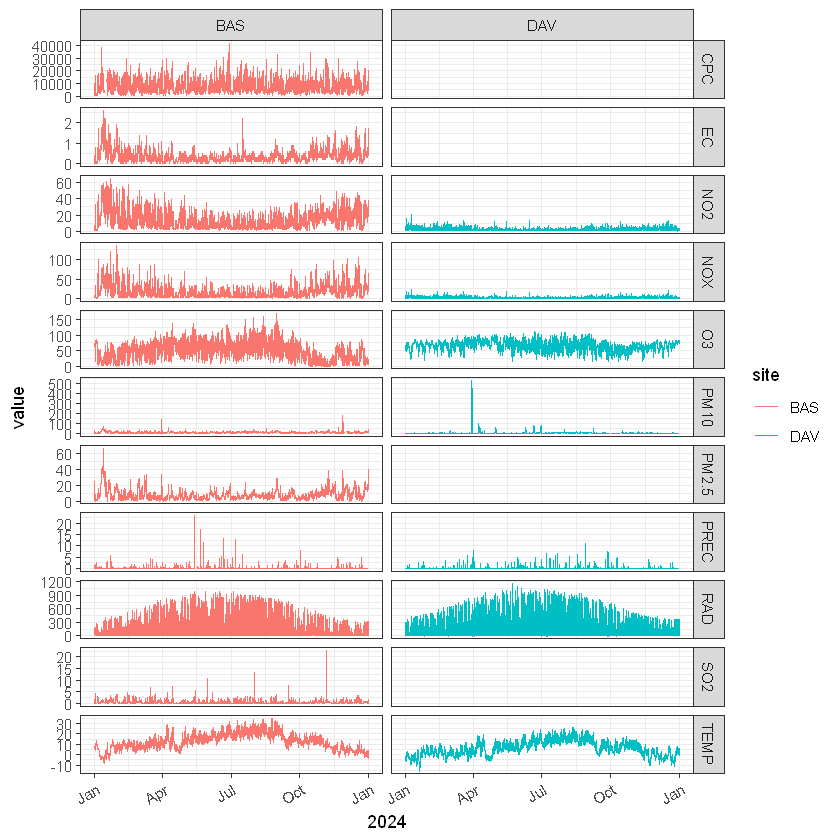

In [11]:
  ggplot(all_data_lf)+                                        # `lf` is the data frame
  facet_grid(variable~site, scale="free_y")+         # panels created out of these variables
  geom_line(aes(datetime, value, color=site))+       # plot `value` vs. `time` as lines
  scale_x_datetime("2024", date_labels = "%b") +
  theme(axis.text.x=element_text(angle=30, hjust=1)) # rotate x-axis labels

## geom_line counts the segments and not the actual number of NA values removed

In [12]:
## There are more NA values than segments because we have consecutive Na Values
sum(is.na(all_data_lf$value))

[1] 36281

In [13]:
sum(is.na(all_data_lf$value))

[1] 36281

In [14]:
colSums(is.na(all_data_df))

site datetime     year    month      day     hour  dayofwk  daytype 
       0        0        0        0        0        0        0        0 
  season       O3      NO2     PM10      NOX     TEMP     PREC      RAD 
       0       85       96      211       96        0       73        0 
     SO2    PM2.5       EC      CPC 
    8852     9065     8832     8971

In [15]:
subset_data <- all_data_df[grep("BAS", all_data_df$site), ]  # Select rows containing "BAS"
na_count_BAS <- colSums(is.na(subset_data))  # Count NA values per column
na_count_BAS

site datetime     year    month      day     hour  dayofwk  daytype 
       0        0        0        0        0        0        0        0 
  season       O3      NO2     PM10      NOX     TEMP     PREC      RAD 
       0       67       74      113       74        0       72        0 
     SO2    PM2.5       EC      CPC 
      68      281       48      187

In [16]:
subset_data <- all_data_df[grep("BAS", all_data_df$site), ]  # Select rows containing "BAS"
na_count_BAS <- colSums(is.na(subset_data))  # Count NA values per column
na_count_BAS

site datetime     year    month      day     hour  dayofwk  daytype 
       0        0        0        0        0        0        0        0 
  season       O3      NO2     PM10      NOX     TEMP     PREC      RAD 
       0       67       74      113       74        0       72        0 
     SO2    PM2.5       EC      CPC 
      68      281       48      187

### Tests

Warning message:
"Removed 36281 rows containing non-finite values (`stat_boxplot()`)."


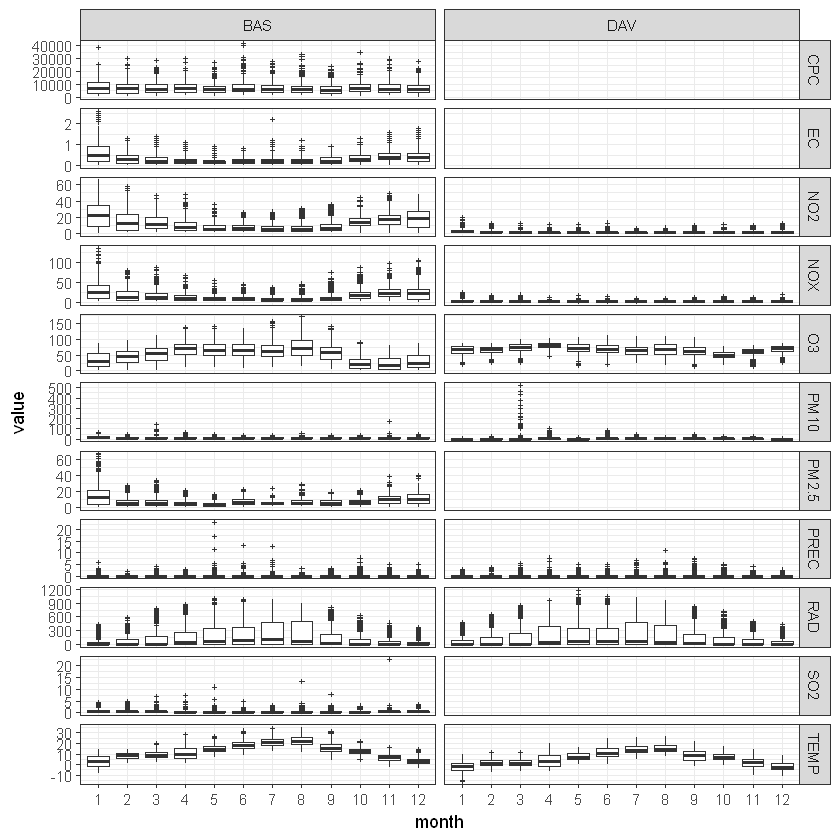

In [17]:
#monthly display example
all_data_lf %>% 
  mutate(month = factor(month)) %>%
  ggplot +
  facet_grid(variable ~ site, scale = "free_y") +
  geom_boxplot(aes(month, value), outlier.size = 0.5, outlier.shape = 3)

Warning message:
"Removed 36281 rows containing non-finite values (`stat_boxplot()`)."


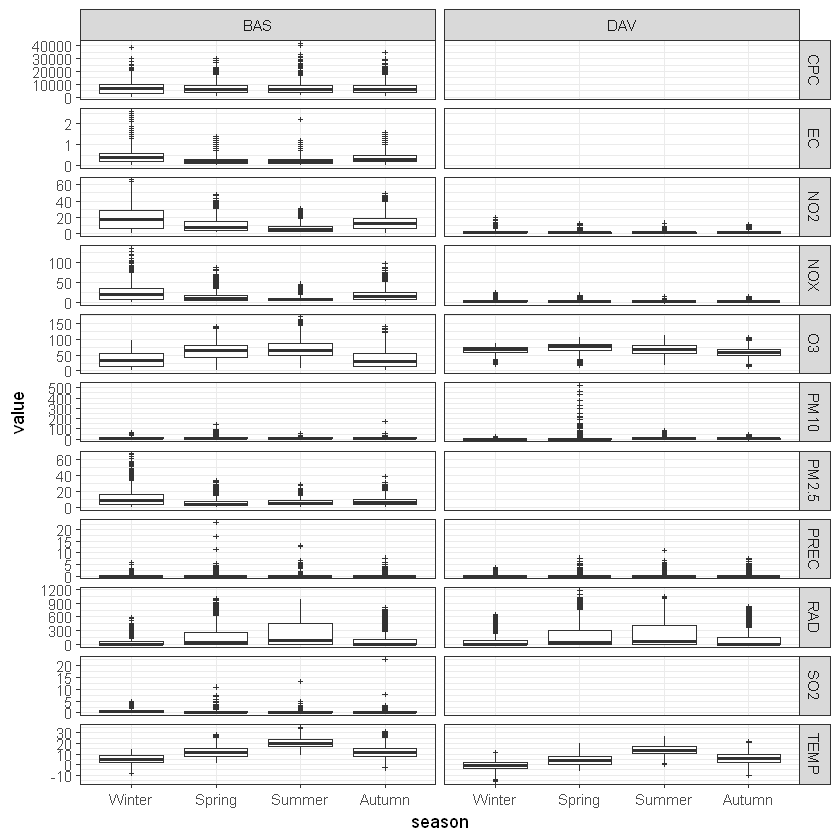

In [18]:
# separated by site
all_data_lf %>% 
  #mutate(month = factor(month)) %>%
  ggplot +
  facet_grid(variable ~ site, scale = "free_y") +
  geom_boxplot(aes(season, value), outlier.size = 0.5, outlier.shape = 3)

### Actual results

In [19]:
library(dplyr)

# Calculate the average values excluding certain variables
avg_values <- all_data_lf %>%
  filter(!variable %in% c("CPC", "EC", "NOX")) %>%  # Exclude these variables
  group_by(site, season, variable) %>%
  summarise(mean_value = mean(value, na.rm = TRUE)) %>%
  ungroup()

# Print the table to the console
avg_values

# Optionally, write the table to a CSV file
write.csv(avg_values, "outputs/seasonal_average_values.csv", row.names = FALSE)

`summarise()` has grouped output by 'site', 'season'. You can override using the `.groups` argument.


site,season,variable,mean_value
<chr>,<fct>,<chr>,<dbl>
BAS,Winter,NO2,19.13648331
BAS,Winter,O3,36.18704397
BAS,Winter,PM10,12.82572227
BAS,Winter,PM2.5,11.10361620
BAS,Winter,PREC,0.07614469
BAS,Winter,RAD,49.77142857
BAS,Winter,SO2,0.68165653
BAS,Winter,TEMP,4.68704212
BAS,Spring,NO2,10.57496599


#### First trial

Warning message:
"Removed 18382 rows containing non-finite values (`stat_boxplot()`)."
Warning message:
"Removed 18382 rows containing non-finite values (`stat_boxplot()`)."


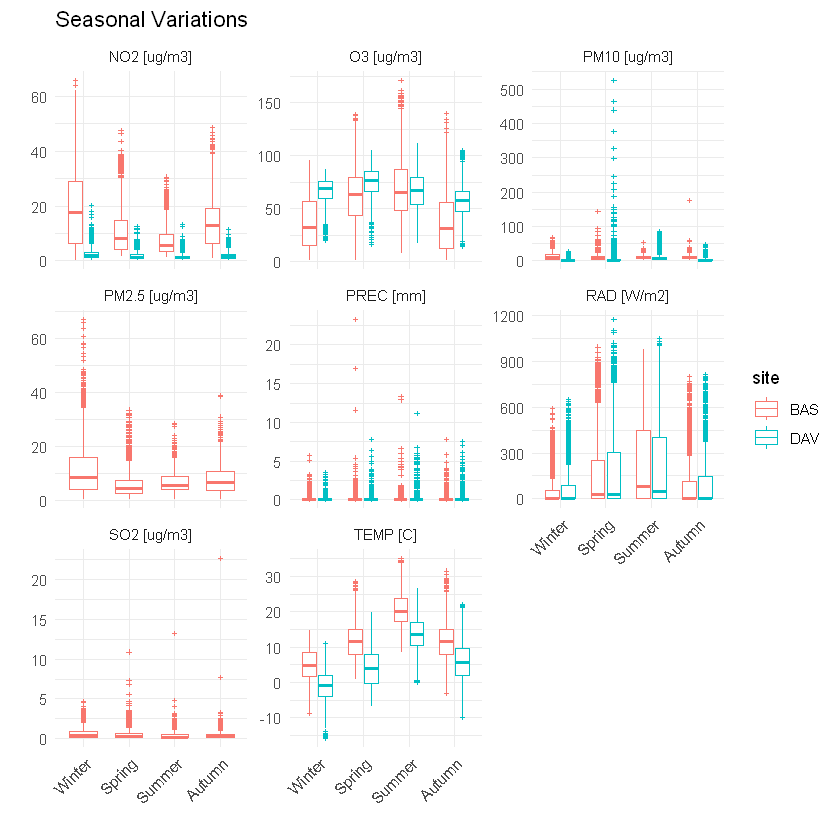

In [20]:
## Saving seasonal plot 
seasonal_variations <- all_data_lf %>% 
  filter(!variable %in% c("CPC", "EC", "NOX"))  # Exclude these variables
  

seasonal_averages_plot <- ggplot(seasonal_variations) +
  facet_wrap(~ variable, scales = "free_y", labeller = labeller(
    variable = c(
      "NO2" =  "NO2 [ug/m3]",
      "O3" = "O3 [ug/m3]",
      "PM10" = "PM10 [ug/m3]",
      "PM2.5" = "PM2.5 [ug/m3]",
      "PREC" = "PREC [mm]",
      "RAD" = "RAD [W/m2]",
      "SO2" = "SO2 [ug/m3]",
      "TEMP" = "TEMP [C]"
    ))) +  # Facet by variable only
  geom_boxplot(
    aes(x = season, 
        y = value, 
        color = site, 
        #fill = season
       ), 
    outlier.size = 0.5, 
    outlier.shape = 3,
    width = 0.6,  # Default is 0.5; increase this to widen the box
    position = position_dodge(width = 0.7)  # Controls spacing between site groups
  ) +
    labs(
    x = "",  # Label for the x-axis
    y = "",  # Label for the y-axis
    title = "Seasonal Variations"  # Title for the plot
  ) +
  theme_minimal() + theme(axis.text.x = element_text(angle = 45, hjust = 1))
seasonal_averages_plot

ggsave("outputs/seasonal_variations.jpeg", plot = seasonal_averages_plot, width = 9, height = 6, dpi = 300)

#### Filtered pollutants results

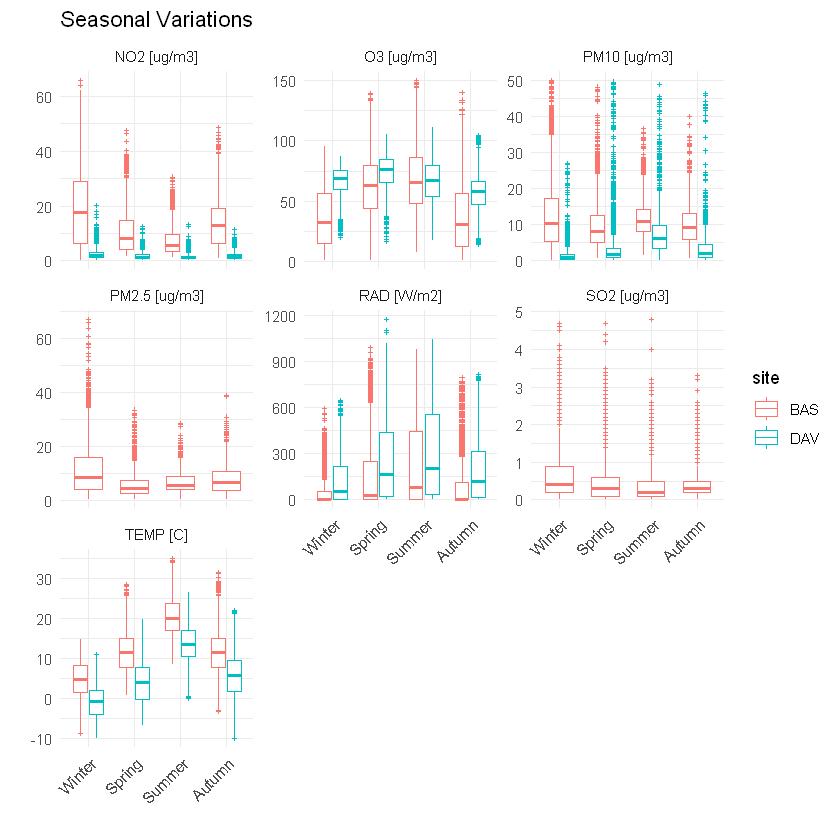

In [21]:
library(ggplot2)
library(dplyr)
library(tibble)

# Define y-axis limits for each variable
y_limits <- tibble::tibble(
  variable = c("NO2", "O3", "PM10", "PM2.5", "PREC", "RAD", "SO2", "TEMP"),
  ymin = c(0, 0, 0, 0, 0, 0, 0, -10),      # Customize lower bounds
  ymax = c(70, 150, 50, 80, 5, 1200, 5, 40)  # Customize upper bounds
)

# Prepare data and apply axis limits
seasonal_variations_limited <- all_data_lf %>% 
  filter(!variable %in% c("CPC", "EC", "NOX", "PREC")) %>%
  left_join(y_limits, by = "variable") %>%
  filter(value >= ymin & value <= ymax)

# Plot
seasonal_averages_plot <- ggplot(seasonal_variations_limited) +
  facet_wrap(~ variable, scales = "free_y", labeller = labeller(
    variable = c(
      "NO2" =  "NO2 [ug/m3]",
      "O3" = "O3 [ug/m3]",
      "PM10" = "PM10 [ug/m3]",
      "PM2.5" = "PM2.5 [ug/m3]",
      "PREC" = "PREC [mm]",
      "RAD" = "RAD [W/m2]",
      "SO2" = "SO2 [ug/m3]",
      "TEMP" = "TEMP [C]"
    ))) +
  geom_boxplot(
    aes(x = season, y = value, color = site),
    outlier.size = 0.5,
    outlier.shape = 3,
    width = 0.6,
    position = position_dodge(width = 0.7)
  ) +
  labs(x = "", y = "", title = "Seasonal Variations") +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))

seasonal_averages_plot

# Save to file
ggsave("outputs/seasonal_variations_capped.jpeg", plot = seasonal_averages_plot, width = 9, height = 6, dpi = 300)


N.B. : We capped PM10 and removed Precipitation data in order to be able to intepret the data correctly

### Precipitation results

`summarise()` has grouped output by 'variable', 'season'. You can override using the `.groups` argument.
Warning message:
"The `size` argument of `element_rect()` is deprecated as of ggplot2 3.4.0.
i Please use the `linewidth` argument instead."


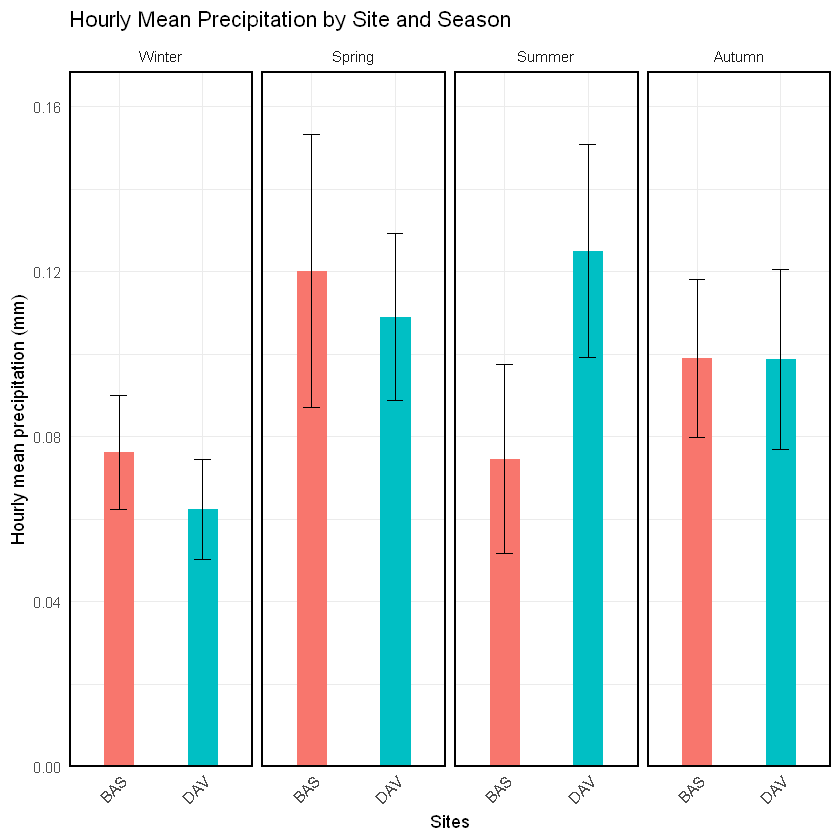

In [22]:
Precipitation_data <- all_data_lf %>%
  filter(!is.na(value) & variable == "PREC" & !is.na(season)) %>%
  group_by(variable, season, site) %>%
  summarise(
    mean_value = mean(value, na.rm = TRUE),
    sd_value = sd(value, na.rm = TRUE),
    n = sum(!is.na(value)),  # Sample size (excluding NA)
    se_value = sd_value / sqrt(n),  # Standard error
    ci_value = qt(0.975, df = n - 1) * se_value  # 95% Confidence Interval
  )

precipitations_plot_1 <-ggplot(Precipitation_data,
    aes(
    x = site, 
    y = mean_value, 
    color = site,
    fill=site
  )
) +
  facet_grid(~ season, scales = "free_y") +
  # Adjust the dodge width for bars and error bars to avoid superimposition
  geom_bar(
    stat = "identity", 
    show.legend = FALSE, 
    position = position_dodge(width = 0.8),  # Separate bars for each site
    width = 0.35  # Adjust bar width to avoid overlap
  ) +  # Mean values as bars
  geom_errorbar(
    aes(ymin = mean_value - ci_value, ymax = mean_value + ci_value), 
    width = 0.2, 
    position = position_dodge(width = 0.8),  # Align error bars with the bars for each site
    color = "black"
  ) +  # 95% CI error bars
  labs(
    x = "Sites",  # Label for the x-axis
    y = "Hourly mean precipitation (mm)",  # Label for the y-axis
    title = "Hourly Mean Precipitation by Site and Season"  # Title for the plot
  ) +
  scale_y_continuous("Hourly mean precipitation (mm)", expand = expansion(mult = c(0, 0.1))) +
  theme_minimal() +
  theme(
    axis.text.x = element_text(angle = 45, hjust = 1),
    strip.text.y = element_text(size = 12, face = "bold"),  # Make facet labels bolder
    panel.border = element_rect(color = "black", fill = NA, size = 1)  # Add box around each facet
  )

precipitations_plot_1

ggsave("outputs/precipitations_sites_1.jpeg", plot = precipitations_plot_1, width = 6, height = 5, dpi = 300)


### Wind results

#### Extracting wind direction

In [23]:
# Step 1: Read the Excel file (starting from row 1, keep header)
wind_direction_data <- read.xlsx(
  "metdata/data/2024/Data_wind_2024_direction_speed.xlsx",
  sheet = 1,
  startRow = 1,       # First row has column names
  colNames = TRUE,
  skipEmptyRows = FALSE
)

# Step 2: Remove rows 2 to 6 (5 rows under the header)
wind_direction_data <- wind_direction_data[-c(1:5), ]
#head(wind_direction_data)

# Step 3: Convert the first column from Excel numeric datetime to POSIXct using Etc/GMT-1
wind_direction_data[[1]] <- as.POSIXct((as.numeric(wind_direction_data[[1]]) - 1/24) * (86400), origin = "1899-12-30", tz = "Etc/GMT+1")

# Check the result (first 20 entries)
#head(wind_direction_data[[1]], 20)

# Optional: Format datetime for pretty printing (e.g., "2025-04-11 00:10:00")
wind_direction_data[[1]] <- format(wind_direction_data[[1]], "%Y-%m-%d %H:%M:%S", tz = "Etc/GMT-1", usetz = TRUE)

# Extract the columns 'station:', 'DAV', and 'BAS'
wind_direction_BAS_DAV <- wind_direction_data[, c("Station:", "DAV", "BAS")]

# Rename the 'station:' column to 'datetime'
colnames(wind_direction_BAS_DAV)[colnames(wind_direction_BAS_DAV) == "Station:"] <- "datetime"
#colnames(wind_direction_BAS_DAV)[colnames(wind_direction_BAS_DAV) == "DAV"] <- "DAV_dir"
#colnames(wind_direction_BAS_DAV)[colnames(wind_direction_BAS_DAV) == "BAS"] <- "BAS_dir"

# Step 4: Convert 'datetime' column to POSIXct (datetime type)
wind_direction_BAS_DAV$datetime <- as.POSIXct(wind_direction_BAS_DAV$datetime, format = "%Y-%m-%d %H:%M:%S", tz = "Etc/GMT-1")

# Check the result
head(wind_direction_BAS_DAV, 30)

,datetime,DAV,BAS
,<dttm>,<chr>,<chr>
6,2024-01-01 00:10:00,52.34,166
7,2024-01-01 00:20:00,25.77,175
8,2024-01-01 00:30:00,33.28,217
9,2024-01-01 00:40:00,35.33,209
10,2024-01-01 00:50:00,34.72,226
11,2024-01-01 01:00:00,27.23,222
12,2024-01-01 01:10:00,43.22,212
13,2024-01-01 01:20:00,25.14,212
14,2024-01-01 01:30:00,28.16,216


In [24]:
# Add year/month/day/hour/minute
wind_direction_BAS_DAV <- wind_direction_BAS_DAV %>%
  mutate(
    year   = year(datetime),
    month  = month(datetime),
    day    = day(datetime),
    hour   = hour(datetime),
    minute = minute(datetime)
  )

In [42]:
wind_direction_BAS_DAV_lf <- wind_direction_BAS_DAV %>%
  pivot_longer(
    cols = c("DAV", "BAS"),      # Columns to gather
    names_to = "site",        # New column for station name
    values_to = "wind_direction"          # New column for the measurement values
  )%>%  
mutate(wind_direction = as.numeric(wind_direction))

In [43]:
wind_direction_BAS_DAV_lf

datetime,year,month,day,hour,minute,site,wind_direction
<dttm>,<dbl>,<dbl>,<int>,<int>,<int>,<chr>,<dbl>
2024-01-01 00:10:00,2024,1,1,0,10,DAV,52.34
2024-01-01 00:10:00,2024,1,1,0,10,BAS,166.00
2024-01-01 00:20:00,2024,1,1,0,20,DAV,25.77
2024-01-01 00:20:00,2024,1,1,0,20,BAS,175.00
2024-01-01 00:30:00,2024,1,1,0,30,DAV,33.28
2024-01-01 00:30:00,2024,1,1,0,30,BAS,217.00
2024-01-01 00:40:00,2024,1,1,0,40,DAV,35.33
2024-01-01 00:40:00,2024,1,1,0,40,BAS,209.00
2024-01-01 00:50:00,2024,1,1,0,50,DAV,34.72


#### Extracting wind speed

In [27]:
# Step 1: Read the Excel file (starting from row 1, keep header)
wind_speed_data <- read.xlsx(
  "metdata/data/2024/Data_wind_2024_direction_speed.xlsx",
  sheet = 2,
  startRow = 1,       # First row has column names
  colNames = TRUE,
  skipEmptyRows = FALSE
)

# Step 2: Remove rows 2 to 6 (5 rows under the header)
wind_speed_data <- wind_speed_data[-c(1:5), ]
#head(wind_direction_data)

# Step 3: Convert the first column from Excel numeric datetime to POSIXct using Etc/GMT-1
wind_speed_data[[1]] <- as.POSIXct((as.numeric(wind_speed_data[[1]]) - 1/24) * (86400), origin = "1899-12-30", tz = "Etc/GMT+1")

# Check the result (first 20 entries)
#head(wind_direction_data[[1]], 20)

# Optional: Format datetime for pretty printing (e.g., "2025-04-11 00:10:00")
wind_speed_data[[1]] <- format(wind_speed_data[[1]], "%Y-%m-%d %H:%M:%S", tz = "Etc/GMT-1", usetz = TRUE)

# Check the result
#head(wind_speed_data, 30)

# Extract the columns 'station:', 'DAV', and 'BAS'
wind_speed_DAV_BAS <- wind_speed_data[, c("Station:", "DAV", "BAS")]

# Rename the 'station:' column to 'datetime'
colnames(wind_speed_DAV_BAS)[colnames(wind_speed_DAV_BAS) == "Station:"] <- "datetime"
#colnames(wind_speed_DAV_BAS)[colnames(wind_speed_DAV_BAS) == "DAV"] <- "DAV_speed"
#colnames(wind_speed_DAV_BAS)[colnames(wind_speed_DAV_BAS) == "BAS"] <- "BAS_speed"

# Step 4: Convert 'datetime' column to POSIXct (datetime type)
wind_speed_DAV_BAS$datetime <- as.POSIXct(wind_speed_DAV_BAS$datetime, format = "%Y-%m-%d %H:%M:%S", tz = "Etc/GMT-1")

# Check the result
head(wind_speed_DAV_BAS, 30)

,datetime,DAV,BAS
,<dttm>,<chr>,<chr>
6,2024-01-01 00:10:00,0.88,1.1000000000000001
7,2024-01-01 00:20:00,0.94,1.1000000000000001
8,2024-01-01 00:30:00,0.91,0.7
9,2024-01-01 00:40:00,1.29,1
10,2024-01-01 00:50:00,1.47,3.8
11,2024-01-01 01:00:00,0.76,5
12,2024-01-01 01:10:00,1.37,4.2
13,2024-01-01 01:20:00,1.24,4.3
14,2024-01-01 01:30:00,1.2,3.8


In [28]:
# Add year/month/day/hour/minute
wind_speed_DAV_BAS <- wind_speed_DAV_BAS %>%
  mutate(
    year   = year(datetime),
    month  = month(datetime),
    day    = day(datetime),
    hour   = hour(datetime),
    minute = minute(datetime)
  )

In [44]:
wind_speed_DAV_BAS_lf <- wind_speed_DAV_BAS %>%
  pivot_longer(
    cols = c("DAV", "BAS"),      # Columns to gather
    names_to = "site",        # New column for station name
    values_to = "wind_speed"          # New column for the measurement values
  )%>%  
mutate(wind_speed = as.numeric(wind_speed))

In [45]:
wind_speed_DAV_BAS_lf

datetime,year,month,day,hour,minute,site,wind_speed
<dttm>,<dbl>,<dbl>,<int>,<int>,<int>,<chr>,<dbl>
2024-01-01 00:10:00,2024,1,1,0,10,DAV,0.88
2024-01-01 00:10:00,2024,1,1,0,10,BAS,1.10
2024-01-01 00:20:00,2024,1,1,0,20,DAV,0.94
2024-01-01 00:20:00,2024,1,1,0,20,BAS,1.10
2024-01-01 00:30:00,2024,1,1,0,30,DAV,0.91
2024-01-01 00:30:00,2024,1,1,0,30,BAS,0.70
2024-01-01 00:40:00,2024,1,1,0,40,DAV,1.29
2024-01-01 00:40:00,2024,1,1,0,40,BAS,1.00
2024-01-01 00:50:00,2024,1,1,0,50,DAV,1.47


#### Merging dataframes

In [46]:
wind_data <- full_join(wind_speed_DAV_BAS_lf, wind_direction_BAS_DAV_lf)

Joining with `by = join_by(datetime, year, month, day, hour, minute, site)`


In [47]:
wind_data

datetime,year,month,day,hour,minute,site,wind_speed,wind_direction
<dttm>,<dbl>,<dbl>,<int>,<int>,<int>,<chr>,<dbl>,<dbl>
2024-01-01 00:10:00,2024,1,1,0,10,DAV,0.88,52.34
2024-01-01 00:10:00,2024,1,1,0,10,BAS,1.10,166.00
2024-01-01 00:20:00,2024,1,1,0,20,DAV,0.94,25.77
2024-01-01 00:20:00,2024,1,1,0,20,BAS,1.10,175.00
2024-01-01 00:30:00,2024,1,1,0,30,DAV,0.91,33.28
2024-01-01 00:30:00,2024,1,1,0,30,BAS,0.70,217.00
2024-01-01 00:40:00,2024,1,1,0,40,DAV,1.29,35.33
2024-01-01 00:40:00,2024,1,1,0,40,BAS,1.00,209.00
2024-01-01 00:50:00,2024,1,1,0,50,DAV,1.47,34.72


#### Calculating hourly mean wind values

In [48]:
mean.angle <- function(theta, r=1, ...) {
  ## Function for averaging angles
  ## Polar coordinates -> Cartesian coordinates -> polar coordinates
  ##   'theta' is in degrees
  ##   'r=1' for unit circle
  ##   returns value is mean theta in degrees
  theta.rad <- theta * pi/180
  x <- mean(r * cos(theta.rad), ...)
  y <- mean(r * sin(theta.rad), ...)
  theta.deg <- atan2(y, x) * 180/pi
  ifelse(sign(theta.deg) < 0, (theta.deg + 360) %% 360, theta.deg) # -179--180 to 0--359
}

In [67]:
hourly_wind_data <- wind_data %>%
  #filter(!variable %in% c("CPC", "EC", "NOX")) %>%  # Exclude these variables
  group_by(site,year,month,day,hour) %>%
  summarise(
    avg_wind_speed = mean(wind_speed, na.rm = TRUE),
    avg_wind_direction = mean.angle(wind_direction, na.rm = TRUE)
  ) %>%
  ungroup()

`summarise()` has grouped output by 'site', 'year', 'month', 'day'. You can override using the `.groups` argument.


In [68]:
hourly_wind_data

site,year,month,day,hour,avg_wind_speed,avg_wind_direction
<chr>,<dbl>,<dbl>,<int>,<int>,<dbl>,<dbl>
BAS,2024,1,1,0,1.540000,198.81582
BAS,2024,1,1,1,4.150000,212.99802
BAS,2024,1,1,2,3.583333,244.97006
BAS,2024,1,1,3,3.166667,211.83428
BAS,2024,1,1,4,2.933333,225.68166
BAS,2024,1,1,5,2.350000,244.17098
BAS,2024,1,1,6,2.816667,233.16739
BAS,2024,1,1,7,3.616667,246.67329
BAS,2024,1,1,8,1.916667,257.91825


#### Merging wind and pollutant dataframes 

In [71]:
df <- left_join(all_data_lf,
                hourly_wind_data)
df

Joining with `by = join_by(site, year, month, day, hour)`


site,datetime,year,month,day,hour,dayofwk,daytype,season,variable,value,avg_wind_speed,avg_wind_direction
<chr>,<dttm>,<dbl>,<dbl>,<int>,<int>,<ord>,<chr>,<fct>,<chr>,<dbl>,<dbl>,<dbl>
DAV,2024-01-01 00:00:00,2024,1,1,0,Mon,Weekday,Winter,O3,57.7,1.0980000,36.25794
DAV,2024-01-01 00:00:00,2024,1,1,0,Mon,Weekday,Winter,NO2,1.9,1.0980000,36.25794
DAV,2024-01-01 00:00:00,2024,1,1,0,Mon,Weekday,Winter,PM10,1.2,1.0980000,36.25794
DAV,2024-01-01 00:00:00,2024,1,1,0,Mon,Weekday,Winter,NOX,1.9,1.0980000,36.25794
DAV,2024-01-01 00:00:00,2024,1,1,0,Mon,Weekday,Winter,TEMP,-2.2,1.0980000,36.25794
DAV,2024-01-01 00:00:00,2024,1,1,0,Mon,Weekday,Winter,PREC,0.0,1.0980000,36.25794
DAV,2024-01-01 00:00:00,2024,1,1,0,Mon,Weekday,Winter,RAD,-0.6,1.0980000,36.25794
DAV,2024-01-01 00:00:00,2024,1,1,0,Mon,Weekday,Winter,SO2,NA,1.0980000,36.25794
DAV,2024-01-01 00:00:00,2024,1,1,0,Mon,Weekday,Winter,PM2.5,NA,1.0980000,36.25794


#### Visualizing winds

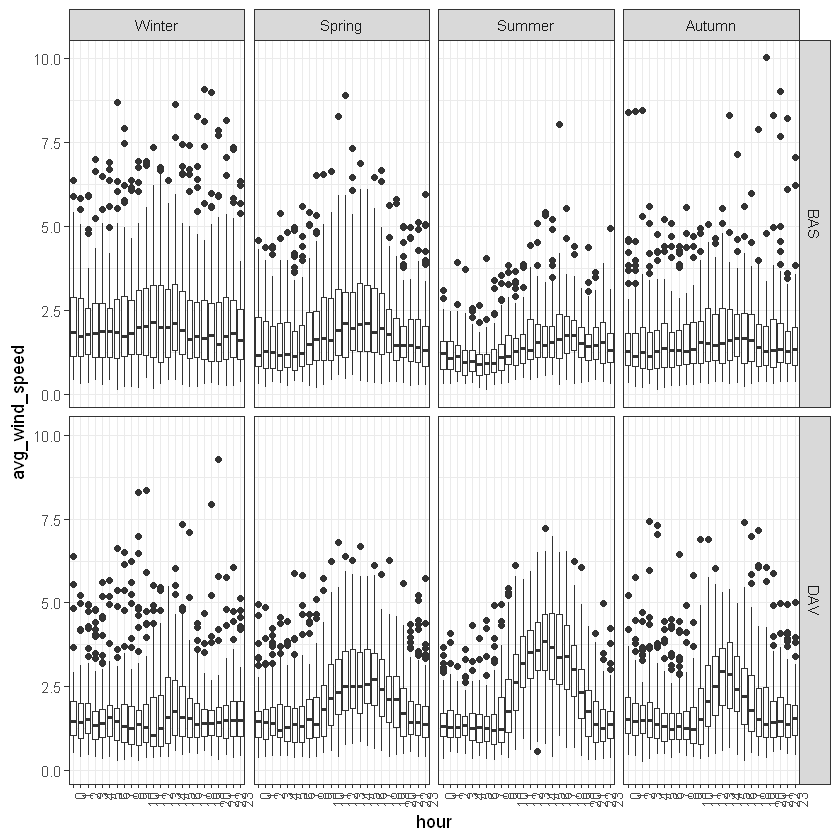

In [73]:
df %>%
  mutate(hour = factor(hour)) %>%
  ggplot+
  facet_grid(site~season)+
  geom_boxplot(aes(hour, avg_wind_speed))+
  theme(axis.text.x = element_text(angle = 90, hjust = 1))

In [75]:
## WindRose.R
library(ggplot2)
library(RColorBrewer)

plotWindrose <- function(data,
                         spd        = "speed",
                         dir        = "direction",
                         spdres     = 2,
                         dirres     = 30,
                         spdmin     = floor(min(data[[spd]], na.rm=TRUE)),
                         spdmax     = ceiling(max(data[[spd]], na.rm=TRUE)),
                         palette    = "YlGnBu",
                         countmax   = NA,
                         decreasing = FALSE,
                         debug      = 0) {

  ## check inputs ----
  if (debug>0){
    cat("Speed = ", spd, "\n")
    cat("Direction = ", dir, "\n")
  }

  ## Tidy up input data ----
  dnu <- (is.na(data[[spd]]) | is.na(data[[dir]]))
  data<- data[!dnu,]

  ## figure out the wind speed bins ----
  n.colors.in.range <- length(seq(spdmin,spdmax,spdres))-1
  speedcuts.colors = colorRampPalette(brewer.pal(min(max(3,
                                                         n.colors.in.range),
                                                     min(9,
                                                         n.colors.in.range)),
                                                 palette))(n.colors.in.range)
  
  speedcuts.breaks <- c(seq(spdmin,spdmax,by = spdres))
  speedcuts.labels <- paste(c(seq(spdmin,spdmax-spdres,by = spdres)),
                            '-',
                            c(seq(spdmin+spdres,spdmax,by = spdres)))
  
  if(max(speedcuts.breaks) < spdmax){ ## edit 05.04.2019
    spdmax. <- spdmax + spdres
    speedcuts.breaks <- c(seq(spdmin,spdmax.,by = spdres))
    speedcuts.labels <- paste(c(seq(spdmin,spdmax.-spdres,by = spdres)),
                              '-',
                              c(seq(spdmin+spdres,spdmax.,by = spdres)))
    speedcuts.colors <- c(speedcuts.colors, "grey50")
  }

  if (debug > 0){
    cat(speedcuts.colors, "\n")
  }

  ## Bin wind speed data ----
  data$spd.binned <- cut(data[[spd]],
                         breaks = speedcuts.breaks,
                         labels = speedcuts.labels,
                         include.lowest = TRUE, # edit 05.04.2019
                         ordered_result = TRUE)
  if(!decreasing) { ## ST
    ## reverse order
    data$spd.binned <- with(data, factor(spd.binned, rev(levels(spd.binned))))
    speedcuts.colors <- rev(speedcuts.colors)
  }

  ## figure out the wind direction bins
  dir.breaks <- c(-dirres/2,
                  seq(dirres/2, 360-dirres/2, by = dirres),
                  360+dirres/2)
  dir.labels <- c(paste(360-dirres/2,"-",dirres/2),
                  paste(seq(dirres/2, 360-3*dirres/2, by = dirres),
                        "-",
                        seq(3*dirres/2, 360-dirres/2, by = dirres)),
                  paste(360-dirres/2,"-",dirres/2))

  ## assign each wind direction to a bin
  if (debug>0){
    cat(dir.breaks,"\n")
    cat(dir.labels,"\n")
  }

  data$dir.binned <- cut(data[[dir]],
                         breaks = dir.breaks,
                         ordered_result = TRUE)
  levels(data$dir.binned) <- dir.labels

  ## Run debug if required ----
  if (debug>0){
    cat("levels(dir.binned) = ",levels(data$dir.binned),"\n")
    cat("names(data) = ", names(data), "\n")
    if (debug >1){
      cat(spd.binned,"\n")
      cat(dir.binned,"\n")
    }
  }

  ## create the plot ----
  plot.windrose <- ggplot(data = data,
                          aes(x = dir.binned,
                              fill = spd.binned)) +
    geom_bar()

  plot.windrose <- plot.windrose +
    scale_x_discrete(drop = FALSE,
                     labels = waiver()) +
    coord_polar(start = -((dirres/2)/360) * 2*pi) +
    scale_fill_manual(name = "Wind Speed (m/s)",
                      values = speedcuts.colors,
                      drop = FALSE) +
    labs(x = "") ## so it doesn't conflict with theme()
  ## theme(axis.title.x = element_blank())

  ## adjust axes if required
  if (!is.na(countmax)){
    plot.windrose <- plot.windrose +
      ylim(c(0,countmax))
  }

  ## print the plot
  ## print(plot.windrose)
  if(!decreasing) { ## ST
    plot.windrose <- plot.windrose +
      guides(fill = guide_legend(reverse = TRUE))
  }

  ## return the handle to the wind rose
  return(plot.windrose)
}

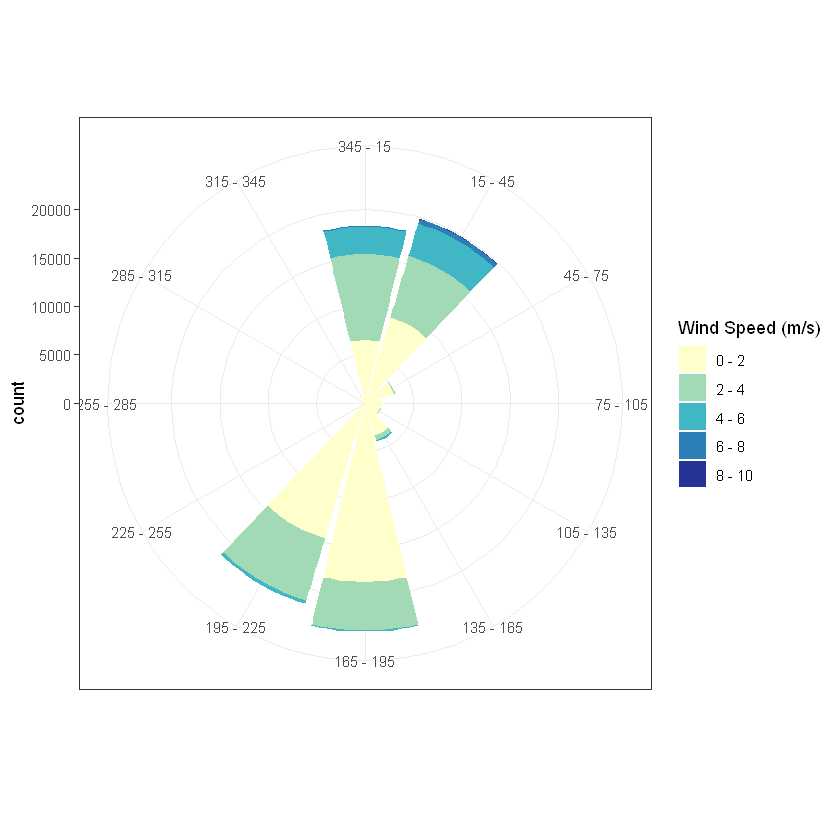

In [77]:
df %>%
  filter(site=="DAV") %>%
  plotWindrose(spd = "avg_wind_speed", dir = "avg_wind_direction", decreasing=FALSE)

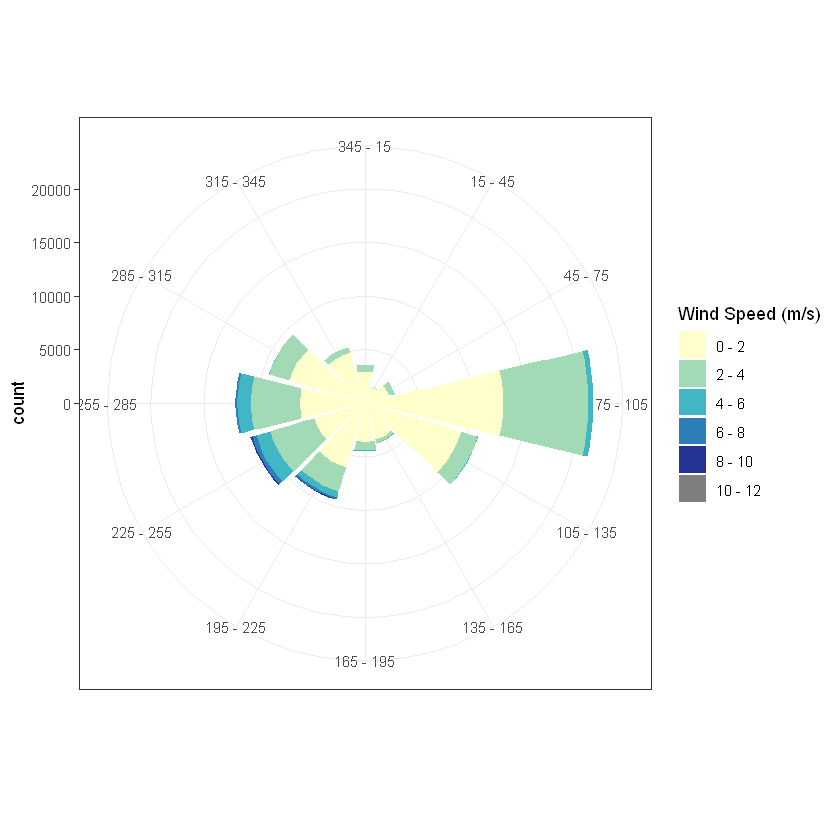

In [78]:
df %>%
  filter(site=="BAS") %>%
  plotWindrose(spd = "avg_wind_speed", dir = "avg_wind_direction", decreasing=FALSE)

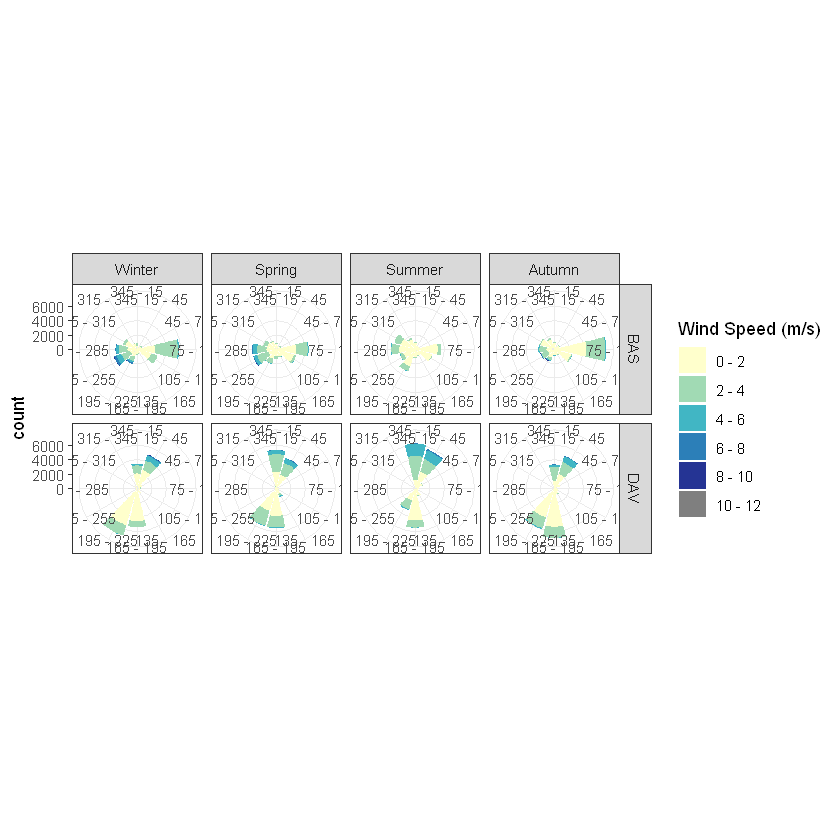

In [84]:
seasons_windrose_plot <- df %>%
plotWindrose(spd = "avg_wind_speed", dir = "avg_wind_direction", decreasing=FALSE) +
  facet_grid(site~season)

seasons_windrose_plot
ggsave("outputs/season_windroses.jpeg", plot = seasons_windrose_plot, width = 12, height = 8, dpi = 300)

# Weekdays vs Weekends > not up to date, see dedicated notebook

### Test

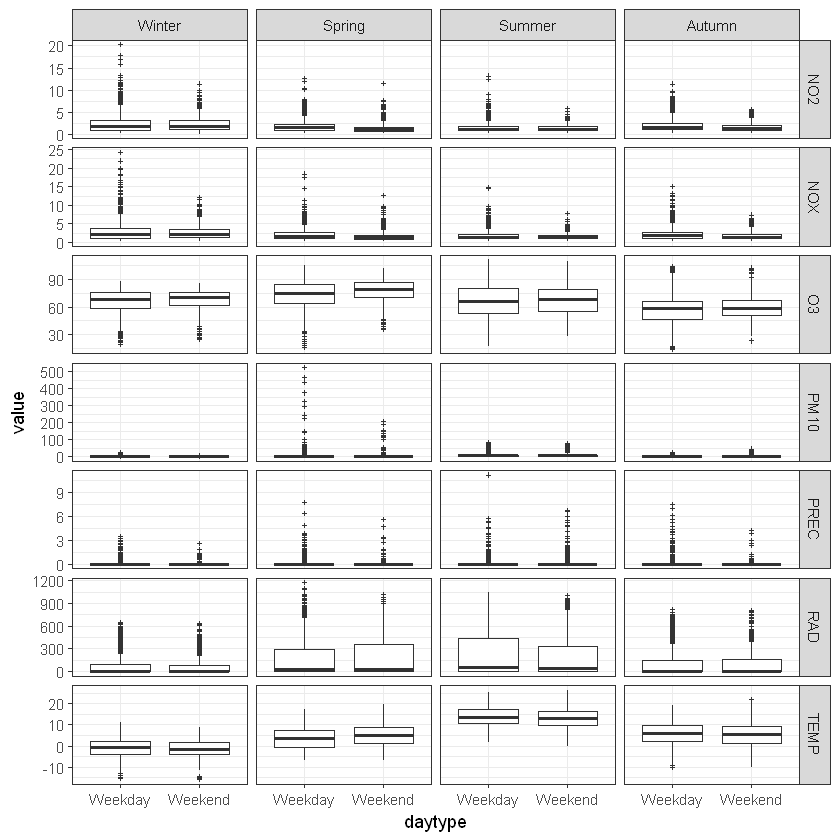

In [29]:
# DAVOS 
all_data_lf %>%
  filter(site=="DAV" & !is.na(value) & !is.na(season)) %>%
  ggplot +
  facet_grid(variable ~ season, scale = "free_y") +
  geom_boxplot(aes(daytype, value), outlier.size = 0.5, outlier.shape = 3)

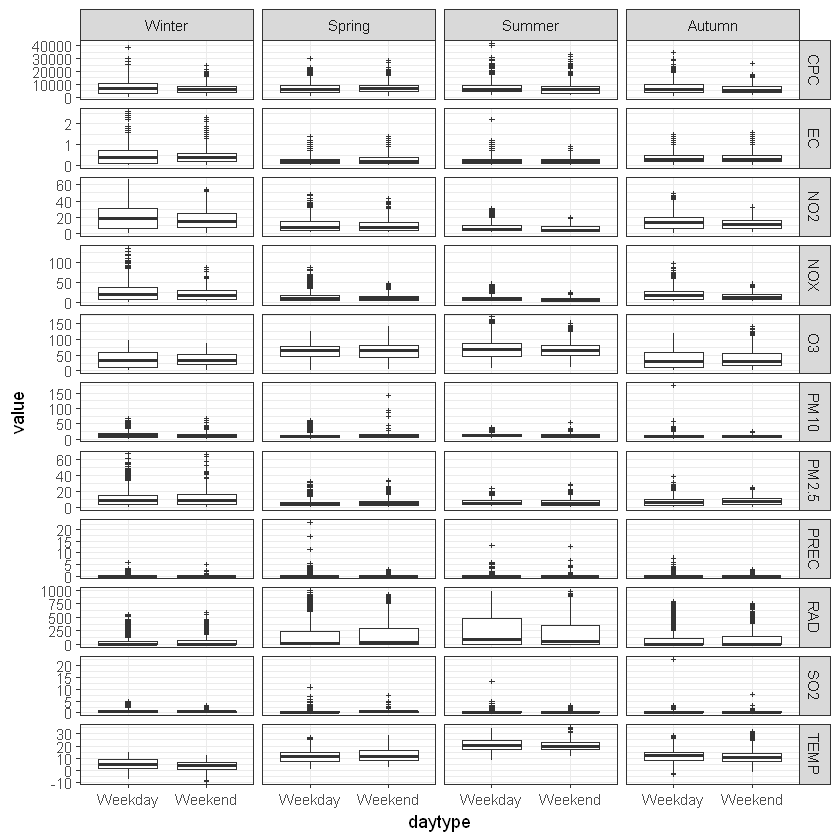

In [30]:
# BASEL
all_data_lf %>%
  filter(site == "BAS" & !is.na(value) & !is.na(season)) %>%
  ggplot +
  facet_grid(variable ~ season, scale = "free_y") +
  geom_boxplot(aes(daytype, value), outlier.size = 0.5, outlier.shape = 3)

### Actual results

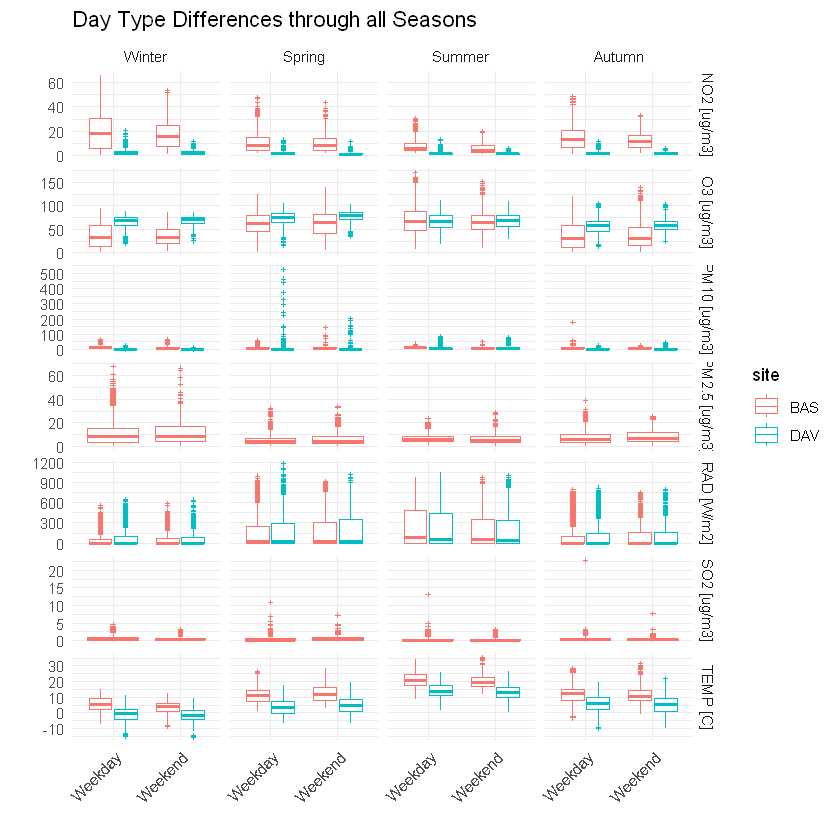

In [57]:
# both sites on the same graph
daytype<-all_data_lf %>%
  filter(!is.na(value) & !is.na(season) & !variable %in% c("CPC", "EC", "NOX", "PREC"))
  
daytype_plot<-ggplot(daytype) +
  facet_grid(variable ~ season, scales = "free_y", labeller = labeller(
    variable = c(
      "NO2" =  "NO2 [ug/m3]",
      "O3" = "O3 [ug/m3]",
      "PM10" = "PM10 [ug/m3]",
      "PM2.5" = "PM2.5 [ug/m3]",
      "PREC" = "PREC [mm]",
      "RAD" = "RAD [W/m2]",
      "SO2" = "SO2 [ug/m3]",
      "TEMP" = "TEMP [C]"
    )
  )) + 
  geom_boxplot(
    aes(x = daytype, y = value, color = site),
    outlier.size = 0.5, 
    outlier.shape = 3
  ) +
    labs(
    x = "",  # Label for the x-axis
    y = "",  # Label for the y-axis
    title = "Day Type Differences through all Seasons"  # Title for the plot
  ) +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))

daytype_plot

ggsave("outputs/daytype.jpeg", plot = daytype_plot, width = 9, height = 9, dpi = 300)

## Precipitation average variations

### Tests

`summarise()` has grouped output by 'daytype', 'variable'. You can override using the `.groups` argument.


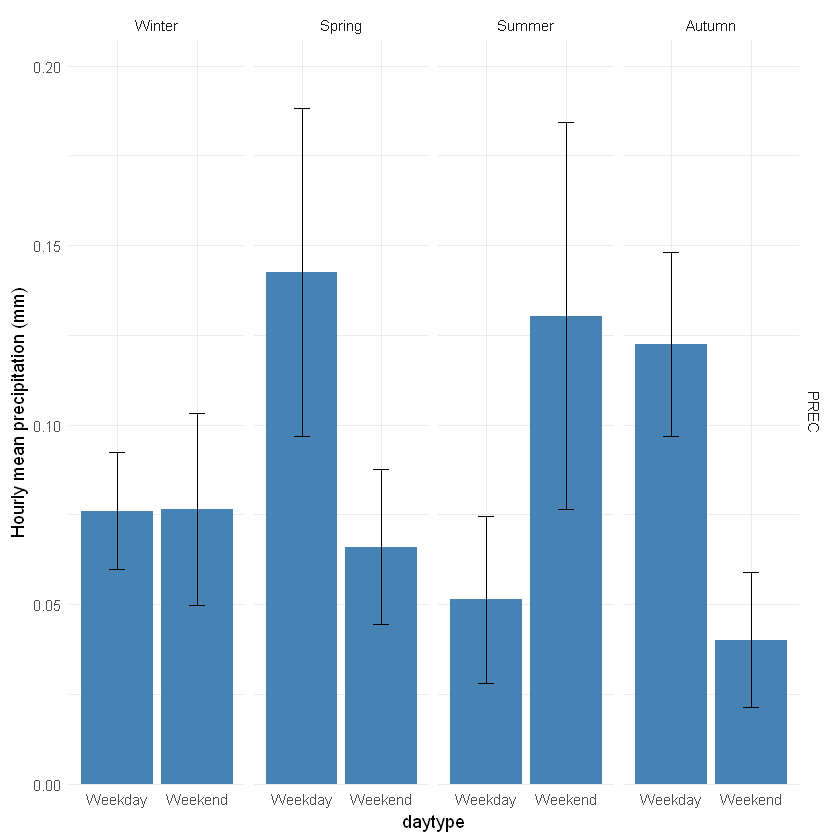

In [32]:
#  precipitation average in BASEL
all_data_lf %>%
  filter(site == "BAS" & !is.na(value) & variable == "PREC" & !is.na(season)) %>%
  group_by(daytype, variable, season) %>%
  summarise(
    mean_value = mean(value, na.rm = TRUE),
    sd_value = sd(value, na.rm = TRUE),
    n = sum(!is.na(value)),  # Sample size (excluding NA)
    se_value = sd_value / sqrt(n),  # Standard error
    ci_value = qt(0.975, df = n - 1) * se_value  # 95% Confidence Interval
  ) %>%
  ggplot(aes(daytype, mean_value)) +
  facet_grid(variable ~ season, scales = "free_y") +
  geom_bar(stat = "identity", show.legend = FALSE, fill = "steelblue") +  # Mean values as bars
  geom_errorbar(aes(ymin = mean_value - ci_value, ymax = mean_value + ci_value), 
                width = 0.2, color = "black") +  # 95% CI error bars
  scale_y_continuous("Hourly mean precipitation (mm)", expand = expansion(mult = c(0, 0.1))) +
  theme_minimal()


Warning message:
"Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
i Please use `linewidth` instead."


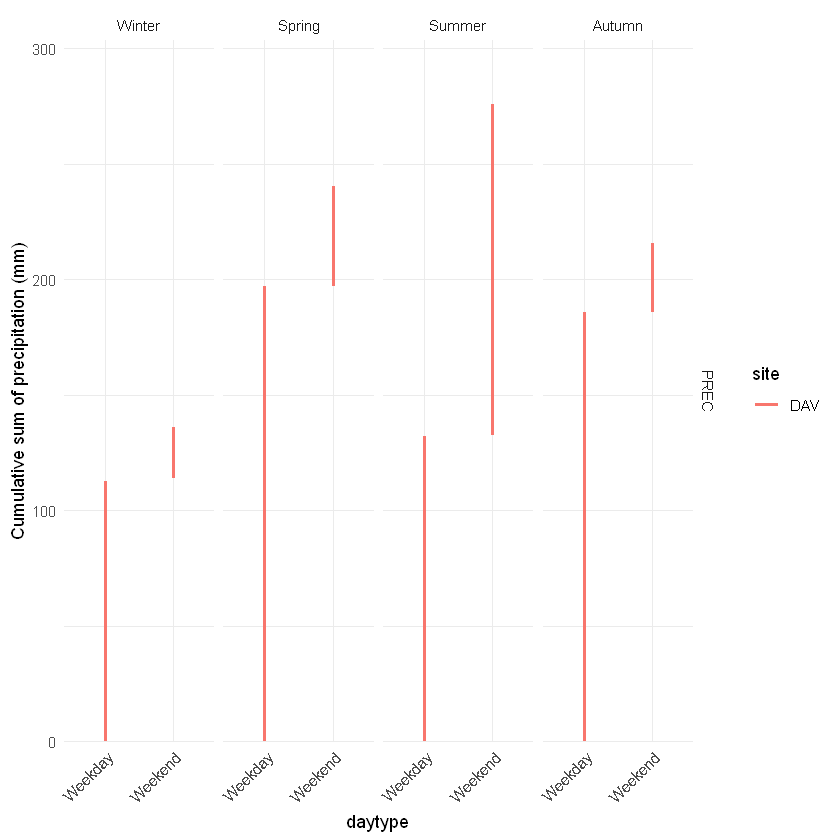

In [33]:
library(dplyr)
library(ggplot2)

# Calculate the cumulative sum of precipitation for site "DAV" and variable "PREC"
cumsum_data <- all_data_lf %>%
  filter(site == "DAV" & !is.na(value) & variable == "PREC" & !is.na(season)) %>%
  arrange(daytype) %>%  # Ensure data is ordered by daytype (time)
  group_by(season) %>%  # If you want to plot by season separately
  mutate(cumsum_value = cumsum(value)) %>%  # Calculate cumulative sum
  ungroup()

# Create the plot
precipitation_plot <- ggplot(cumsum_data, aes(x = daytype, y = cumsum_value)) +
  facet_grid(variable ~ season, scales = "free_y") +  # Facet by season and variable
  geom_line(aes(color = site), size = 1) +  # Line plot to show cumulative precipitation
  scale_y_continuous("Cumulative sum of precipitation (mm)", expand = expansion(mult = c(0, 0.1))) +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))  # Rotate x-axis labels if necessary

# Print the plot
precipitation_plot



### Actual results

`summarise()` has grouped output by 'daytype', 'variable', 'season'. You can override using the `.groups` argument.


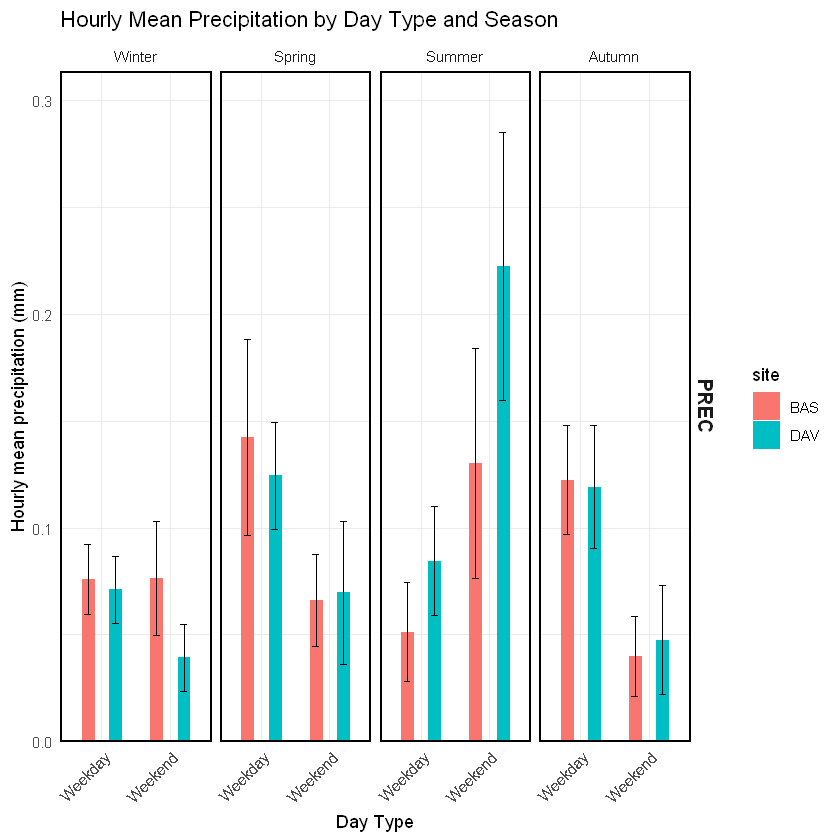

In [52]:
Precipitation_data <- all_data_lf %>%
  filter(!is.na(value) & variable == "PREC" & !is.na(season)) %>%
  group_by(daytype, variable, season, site) %>%
  summarise(
    mean_value = mean(value, na.rm = TRUE),
    sd_value = sd(value, na.rm = TRUE),
    n = sum(!is.na(value)),  # Sample size (excluding NA)
    se_value = sd_value / sqrt(n),  # Standard error
    ci_value = qt(0.975, df = n - 1) * se_value  # 95% Confidence Interval
  )

precipitations_plot_1 <-ggplot(Precipitation_data,
    aes(
    x = daytype, 
    y = mean_value, 
    color = site,
    fill=site
  )
) +
  facet_grid(variable ~ season, scales = "free_y") +
  # Adjust the dodge width for bars and error bars to avoid superimposition
  geom_bar(
    stat = "identity", 
    show.legend = TRUE, 
    position = position_dodge(width = 0.8),  # Separate bars for each site
    width = 0.35  # Adjust bar width to avoid overlap
  ) +  # Mean values as bars
  geom_errorbar(
    aes(ymin = mean_value - ci_value, ymax = mean_value + ci_value), 
    width = 0.2, 
    position = position_dodge(width = 0.8),  # Align error bars with the bars for each site
    color = "black"
  ) +  # 95% CI error bars
  labs(
    x = "Day Type",  # Label for the x-axis
    y = "Log10 of Precipitation (mm)",  # Label for the y-axis
    title = "Hourly Mean Precipitation by Day Type and Season"  # Title for the plot
  ) +
  scale_y_continuous("Hourly mean precipitation (mm)", expand = expansion(mult = c(0, 0.1))) +
  theme_minimal() +
  theme(
    axis.text.x = element_text(angle = 45, hjust = 1),
    strip.text.y = element_text(size = 12, face = "bold"),  # Make facet labels bolder
    panel.border = element_rect(color = "black", fill = NA, size = 1)  # Add box around each facet
  )

precipitations_plot_1

ggsave("outputs/precipitations_DayType_sites.jpeg", plot = precipitations_plot_1, width = 6, height = 5, dpi = 300)


Warning message:
"Transformation introduced infinite values in continuous y-axis"
Warning message:
"Removed 15456 rows containing non-finite values (`stat_boxplot()`)."
Warning message:
"Transformation introduced infinite values in continuous y-axis"
Warning message:
"Removed 15456 rows containing non-finite values (`stat_boxplot()`)."


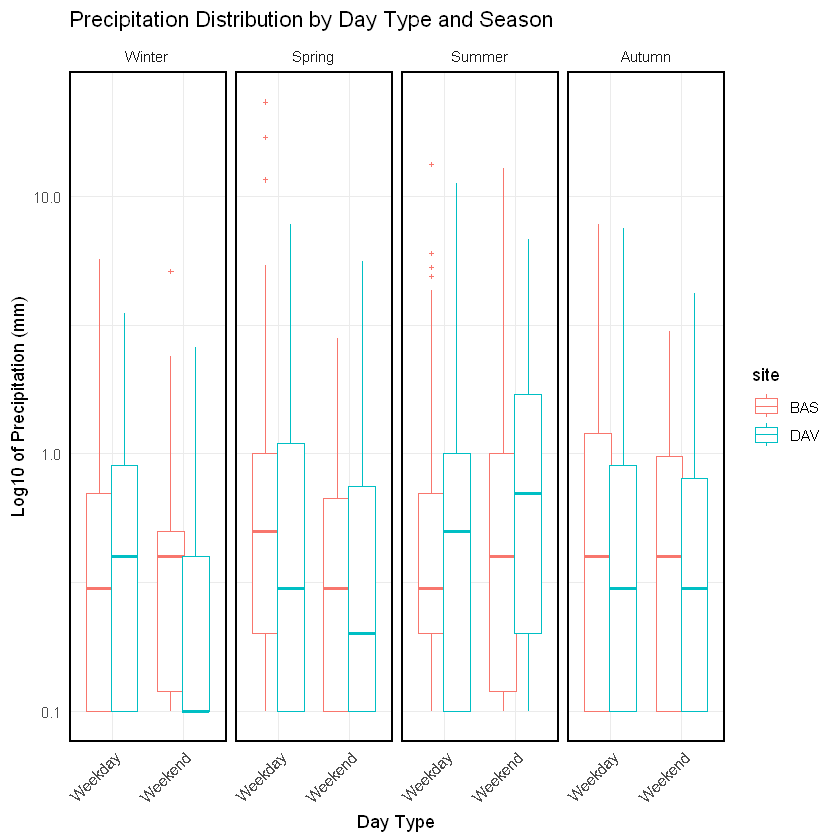

In [35]:
library(ggplot2)
library(dplyr)

# Filter the data for the PREC variable
daytype <- all_data_lf %>%
  filter(!is.na(value) & !is.na(season) & variable == "PREC")

# Create the plot for PREC only, with a log y scale and clear separation of seasons
daytype_plot <- ggplot(daytype) +
  facet_grid(~ season, scales = "free_y", labeller = labeller(
    variable = c(
      "PREC" = "PREC [mm]"
    )
  )) + 
  # Add the rectangle around each season facet
  geom_boxplot(
    aes(x = daytype, y = value, color = site),
    outlier.size = 0.5, 
    outlier.shape = 3,
    position = position_dodge(width = 0.7)  # Separate the boxplots for each season
  ) +
  scale_y_log10() +  # Apply log scale to y-axis
  labs(
    x = "Day Type",  # Label for the x-axis
    y = "Log10 of Precipitation (mm)",  # Label for the y-axis
    title = "Precipitation Distribution by Day Type and Season"  # Title for the plot
  ) +
  theme_minimal() +
  theme(
    axis.text.x = element_text(angle = 45, hjust = 1),
    strip.text.y = element_text(size = 12, face = "bold"),  # Make facet labels bolder
    panel.border = element_rect(color = "black", fill = NA, size = 1)  # Add box around each facet
  )

# Print the plot
daytype_plot

# Save the plot
ggsave("outputs/daytype_prec_log_separated_seasons_with_boxes.jpeg", plot = daytype_plot, width = 6, height = 5, dpi = 300)


### Cummulative precipitaiton variations

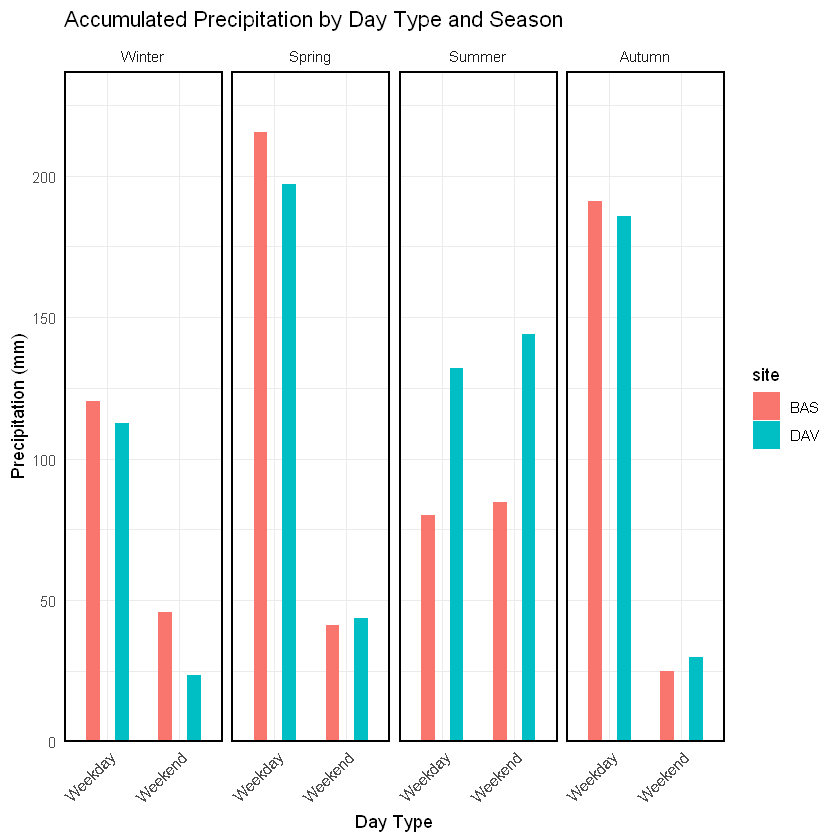

In [53]:
# Filter out NA values and calculate cumulative sum using reframe()
Precipitation_cumsum_data <- all_data_lf %>%
  filter(!is.na(value) & variable == "PREC" & !is.na(season)) %>%
  group_by(daytype, season, site) %>%
  reframe(
    cumsum_value = cumsum(value)  # Compute cumulative sum for each group
  )

# Create the plot
precipitations_plot_2 <- ggplot(Precipitation_cumsum_data, aes(
    x = daytype, 
    y = cumsum_value, 
    color = site,
    fill = site
  )) +
  facet_grid(~ season, scales = "free_y") +
  geom_bar(
    stat = "identity", 
    show.legend = TRUE, 
    position = position_dodge(width = 0.8),  # Separate bars for each site
    width = 0.35  # Adjust bar width to avoid overlap
  ) +
  scale_y_continuous("Precipitation (mm)", expand = expansion(mult = c(0, 0.1))) +  # Adjust label to reflect cumulative values
  theme_minimal() +
    labs(
    x = "Day Type",  # Label for the x-axis
    y = "Precipitation (mm)",  # Label for the y-axis
    title = "Accumulated Precipitation by Day Type and Season"  # Title for the plot
  ) +
  theme(
    axis.text.x = element_text(angle = 45, hjust = 1),
    strip.text.y = element_text(size = 12, face = "bold"),  # Make facet labels bolder
    panel.border = element_rect(color = "black", fill = NA, size = 1)  # Add box around each facet
  )

# Print the plot
precipitations_plot_2

ggsave("outputs/accumulated_precipitations_1.jpeg", plot = precipitations_plot_2, width = 6, height = 5, dpi = 300)
